In [118]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from skimage.morphology import erosion, dilation,binary_erosion, opening, disk
import skimage
import cv2

from skimage.filters.rank import entropy
from skimage import filters

from tp2 import my_segmentation, evaluate

from skimage.morphology import thin

import scipy

## Exploring data + code

Accuracy = 0.14429232549170845, Recall = 0.8434400360685302


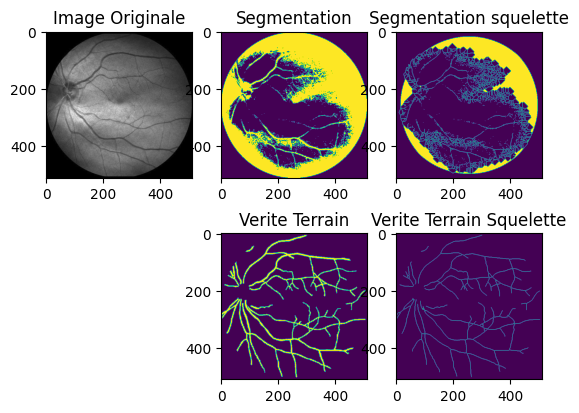

In [119]:
img =  np.asarray(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)

nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]

img_mask = (np.ones(img.shape)).astype(np.bool_)
invalid_pixels = ((row - nrows / 2) ** 2 + (col - ncols / 2) ** 2 > (nrows / 2) ** 2)
img_mask[invalid_pixels] = 0

img_out = my_segmentation(img, img_mask, 85)

img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

evaluate(img_out, img_GT)

img_out_skel = thin(img_out, max_num_iter = 15)
GT_skel = thin(img_GT, max_num_iter = 15)

plt.subplot(231)
plt.imshow(img,cmap = 'gray')
plt.title('Image Originale')
##################################
plt.subplot(232)
plt.imshow(img_out)
plt.title('Segmentation')
##################################
plt.subplot(233)
plt.imshow(img_out_skel)
plt.title('Segmentation squelette')
##################################
plt.subplot(235)
plt.imshow(img_GT)
plt.title('Verite Terrain')
##################################
plt.subplot(236)
plt.imshow(GT_skel)
plt.title('Verite Terrain Squelette')
plt.show()

Accuracy = 0.10056818181818182, Recall = 0.06584821428571429


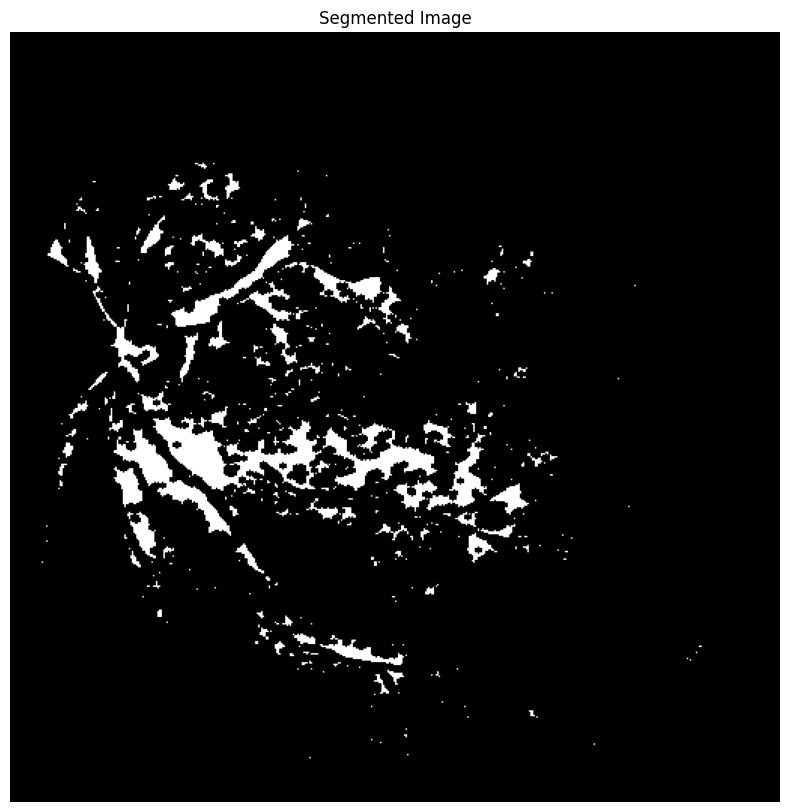

In [120]:
# Charger l'image
image = cv2.imread('./images_IOSTAR/star01_OSC.jpg', 0)  
# image en niveaux de gris

# Prétraitement de l'image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
preprocessed_image = clahe.apply(image)

# Filtrage pour détecter les vaisseaux sanguins
vessel_image = cv2.morphologyEx(preprocessed_image, cv2.MORPH_TOPHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15)))

# Binarisation
ret, binary_image = cv2.threshold(vessel_image, 60, 255, cv2.THRESH_BINARY)

# Post-traitement
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

evaluate(binary_image, img_GT)

# Afficher l'image segmentée
plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.show()


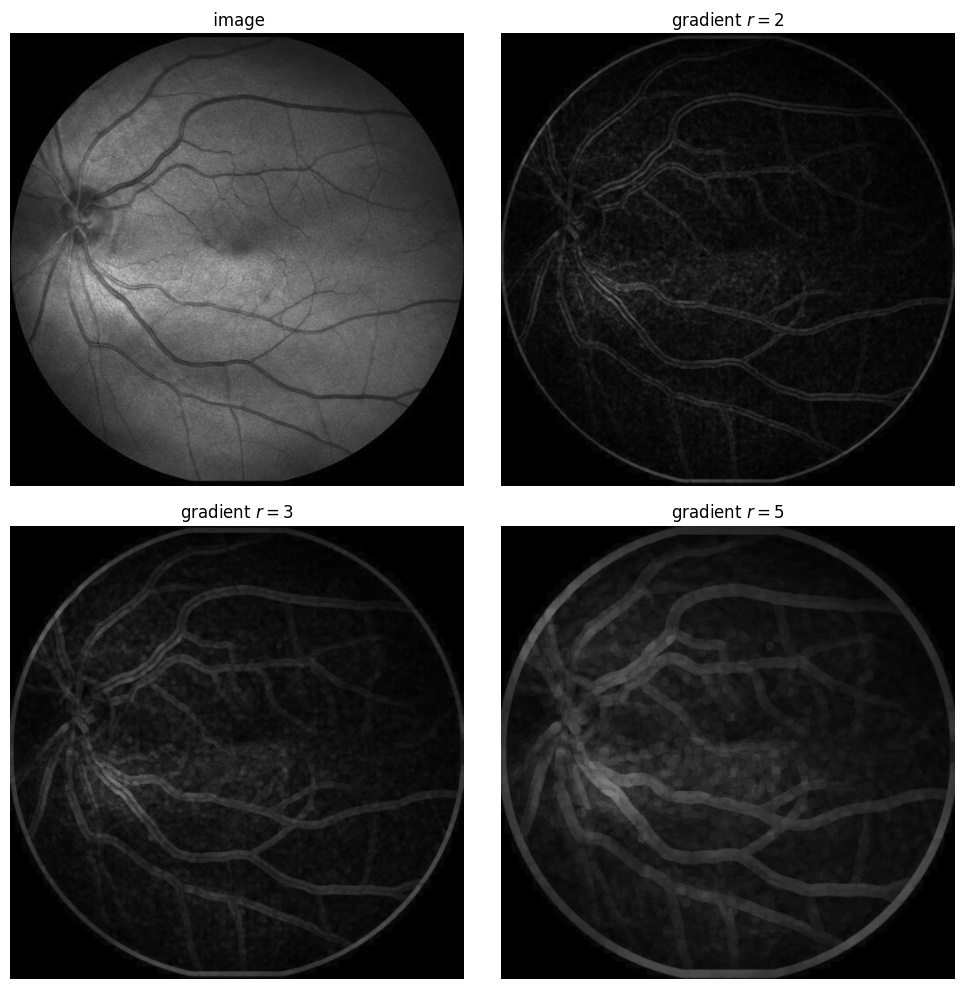

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title(' image')

ax[1].imshow(dilation(image, disk(2)) -erosion(image, disk(2)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('gradient $r=2$')

ax[2].imshow(dilation(image, disk(3))-erosion(image, disk(3)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('gradient $r=3$')

ax[3].imshow(dilation(image, disk(5))-erosion(image, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('gradient $r=5$')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Simulating algorithm

In [122]:
original_image =  np.array(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)

## Matched-filter response

### First possible filter

Accuracy = 0.13005214441279947, Recall = 0.9025542273734695


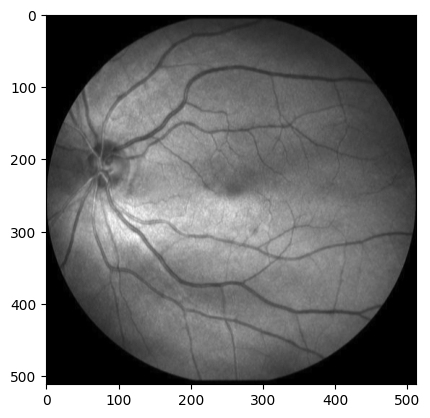

In [123]:
def matched_filter(image, kernel):
    # Convolve the image with the matched filter kernel
    return cv2.filter2D(image, -1, kernel)

gabor_kernel = cv2.getGaborKernel((15, 15), 7, np.pi/3, 6, 0.3) # Testing Gabor filter
gaussian_kernel = cv2.getGaussianKernel(30, np.pi/3) # Testing Gaussian filter

image_with_kernel = matched_filter(original_image, gaussian_kernel)

evaluate(image_with_kernel, img_GT)

plt.imshow(image_with_kernel, cmap = 'gray')

In [125]:
# Function to calculate contrast. The filter (first step of algo) tries to increase contrast in image. With this
# function we could calculate different parameters, filters, etc and compare results with one result.

# To explore also Michelson contrast
def calculate_contrast(image):
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0,256])

    # Normalize histogram
    hist /= hist.sum()

    # Calculate mean intensity
    mean_intensity = np.sum(np.arange(256) * hist[:,0])

    # Calculate contrast (standard deviation of intensities)
    contrast = np.sqrt(np.sum(((np.arange(256) - mean_intensity) ** 2) * hist[:,0]))

    return contrast
    

### Second possible filter

42.469777583749234 73.20932125121098


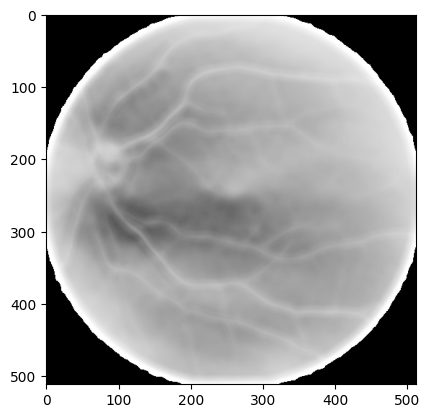

In [128]:
def generate_matched_filter_kernels(alpha, L):
    kernels = []
    for angle in range(0, 180, 15):  # Rotate the kernel in 15-degree increments
        kernel = np.zeros((15, 15))
        x_shape = kernel.shape[0]
        y_shape = kernel.shape[1]
        for x in range(x_shape):
            for y in range(y_shape):
                # Rotate the coordinates
                x_rotated = (x - x_shape / 2) * np.cos(np.radians(angle)) + (y - y_shape / 2) * np.sin(np.radians(angle))
                y_rotated = -(x - x_shape / 2) * np.sin(np.radians(angle)) + (y - y_shape / 2) * np.cos(np.radians(angle))
                # Calculate the kernel value based on the prototype formula
                if abs(y_rotated) <= L / 2:
                    kernel[y, x] = -np.exp(-x_rotated ** 2 / (2 * alpha ** 2))
        kernel /= np.sum(np.abs(kernel))  # To normalize kernels
        kernel = np.asanyarray(kernel, np.float32)
        kernels.append(kernel)
    return kernels

def apply_matched_filter_kernels(image, kernels):
    responses = []
    for kernel in kernels:
        # response = cv2.filter2D(image, -1, kernel) # cv2 library doesn't work very well with kernels
        response = scipy.ndimage.convolve(image, kernel)
        # yield response
        responses.append(response)
    return np.max(responses, axis=0)

alpha = 3  # Adjust as needed
L = 40      # Length of the segment for vessel orientation

# Generate matched filter kernels
kernels = generate_matched_filter_kernels(alpha, L)

# Apply the matched filter kernels
filtered_image = apply_matched_filter_kernels(original_image, kernels)
# for result in apply_matched_filter_kernels(original_image, kernels):

cont_or = calculate_contrast(original_image)
cont_ker = calculate_contrast(filtered_image) # the contrast is higher than in the original picture
print(cont_or, cont_ker)

plt.imshow(filtered_image, cmap = 'gray')


## Local Entropy Thresholding

In [129]:
def local_entropy_threshold(image, window_size):
    height, width = image.shape[:2]
    entropy_image = np.zeros((height, width))

    # Iterate over each pixel in the image
    for y in range(height):
        for x in range(width):
            # Define the local window
            x_min = max(0, x - window_size // 2)
            x_max = min(width, x + window_size // 2)
            y_min = max(0, y - window_size // 2)
            y_max = min(height, y + window_size // 2)

            # Extract the local region
            local_region = image[y_min:y_max, x_min:x_max]

            # Compute the histogram
            hist, _ = np.histogram(local_region.flatten(), bins=256, range=[0, 256])

            # Compute probability distribution
            prob_dist = hist / np.sum(hist)

            # Compute entropy
            entropy = -np.sum(prob_dist * np.log2(prob_dist + 1e-10))  # Adding small value to avoid log(0)

            # Assign entropy to the corresponding pixel
            entropy_image[y, x] = entropy

    return entropy_image

In [130]:
entropy_image = local_entropy_threshold(filtered_image, 2)

In [131]:
_, binary_image = cv2.threshold(entropy_image, 0, 255, cv2.THRESH_BINARY)

Accuracy = 0.17118809649056888, Recall = 0.5742374590370557


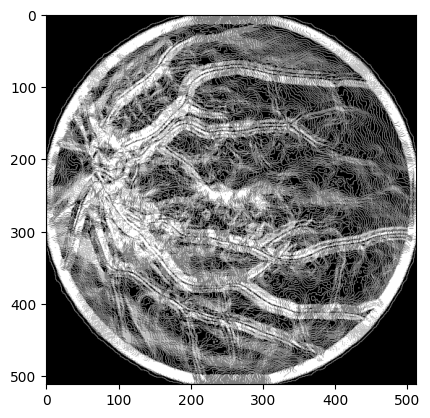

In [132]:
evaluate(entropy_image.astype(np.uint8), img_GT)
plt.imshow(entropy_image, cmap = 'gray')